In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time
from sklearn.preprocessing import MinMaxScaler

# Models

* FM

In [2]:
class FM(nn.Module):
    def __init__(self, n, k):
        super(FM, self).__init__()
        self.n = n
        self.k = k
        self.Feature_Matrix = nn.Parameter(torch.randn(n, k), requires_grad=True)
        self.linear = nn.Linear(n, 1)

    def forward(self, x):
        linear_Layer = self.linear(x)

        p1 = torch.matmul(x, self.Feature_Matrix).pow(2)
        p2 = torch.matmul(x.pow(2), self.Feature_Matrix.pow(2))

        interaction_layer = 0.5 * (p1 - p2).sum(dim=1, keepdim=True)

        return linear_Layer + interaction_layer
        

* BPR Loss

In [3]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

class BPRLoss(nn.Module):
    def __init__(self, item1 = None, item2 = None):
        super(BPRLoss, self).__init__()
        self.item1 = item1
        self.item2 = item2

    def forward(self, item1, item2):
        dist = item1 - item2
        return -torch.sum(torch.log(sigmoid(dist)))


# Train

In [4]:
class MovieLens(Dataset):
    def __init__(self, pair1, pair2):
        self.pair1 = pair1
        self.pair2 = pair2

    def __len__(self):
        return len(self.pair1)

    def __getitem__(self, idx):
        p1 = self.pair1[idx]
        p2 = self.pair2[idx]
        return p1, p2


def data_tensor(dataset):
    scaler = MinMaxScaler()

    user_feature = dataset.iloc[:,0:3]
    movie1_feature = dataset.iloc[:,3:5]
    movie2_feature = dataset.iloc[:,5:7]
    
    positive = user_feature.join(movie1_feature)
    negative = user_feature.join(movie2_feature)

    positive = scaler.fit_transform(positive.values)
    positive = torch.tensor(positive).float()

    negative = scaler.fit_transform(negative.values)
    negative = torch.tensor(negative).float()

    return MovieLens(positive, negative)


In [5]:
batch_size = 1024

train_set_path = {"full": '',
                "sampled":"./data/bpr_sampled_train_set.csv" }
val_set_path = {"full": '',
                "sampled":"./data/bpr_sampled_val_set.csv" }


train_set = pd.read_csv(train_set_path['sampled'], header=0)
val_set = pd.read_csv(val_set_path['sampled'], header=0)


train_set = data_tensor(train_set)
val_set = data_tensor(val_set)


train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, dataloader, optimizer, criterion):
    train_loss = 0
    i = 0
    model.train()
    for pair1, pair2 in dataloader:
        pair1, pair2 = pair1.to(device), pair2.to(device)

        optimizer.zero_grad()
        score1, score2 = model(pair1), model(pair2)
        # print("s1 = ", score1, ", s2 = ", score2)
        loss = criterion(score1, score2)
        train_loss += loss.item()
        # print("loss = ", loss)

        loss.backward()
        optimizer.step()

    return train_loss / len(dataloader.dataset)


In [7]:
def validation(model, dataloader, criterion):
    val_loss = 0
    model.eval()
    for pair1, pair2 in dataloader:
        pair1, pair2 = pair1.to(device), pair2.to(device)
        with torch.no_grad():
            score1, score2 = model(pair1), model(pair2)
        loss = criterion(score1, score2)
        val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [11]:
num_features = 5
num_dimention = 5
model = FM(num_features,num_dimention)
wd=1e-5
lr=1e-3
epochs=20

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8], gamma=0.1)
criterion = BPRLoss()

train_loss_list = []
val_loss_list = []

for epoch in range(epochs):

    train_loss = train(model, train_dataloader, optimizer, criterion)
    val_loss = validation(model, val_dataloader, criterion)
    scheduler.step()

    sqrt_train_loss = (math.sqrt(train_loss))
    sqrt_val_loss = (math.sqrt(val_loss))
    
    print(f'epoch {epoch}:')
    print(f'\ttrain loss: {train_loss:.4f}')
    print(f'\tvalidation loss: {val_loss:.4f}')
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

epoch 0:
	train loss: 0.6930
	validation loss: 0.6939
epoch 1:
	train loss: 0.6926
	validation loss: 0.6941
epoch 2:
	train loss: 0.6926
	validation loss: 0.6934
epoch 3:
	train loss: 0.6926
	validation loss: 0.6936
epoch 4:
	train loss: 0.6926
	validation loss: 0.6941
epoch 5:
	train loss: 0.6926
	validation loss: 0.6933
epoch 6:
	train loss: 0.6926
	validation loss: 0.6932
epoch 7:
	train loss: 0.6926
	validation loss: 0.6931
epoch 8:
	train loss: 0.6925
	validation loss: 0.6934
epoch 9:
	train loss: 0.6925
	validation loss: 0.6936
epoch 10:
	train loss: 0.6925
	validation loss: 0.6932
epoch 11:
	train loss: 0.6925
	validation loss: 0.6934
epoch 12:
	train loss: 0.6925
	validation loss: 0.6935
epoch 13:
	train loss: 0.6925
	validation loss: 0.6934
epoch 14:
	train loss: 0.6925
	validation loss: 0.6933
epoch 15:
	train loss: 0.6925
	validation loss: 0.6934
epoch 16:
	train loss: 0.6925
	validation loss: 0.6934
epoch 17:
	train loss: 0.6925
	validation loss: 0.6935
epoch 18:
	train los

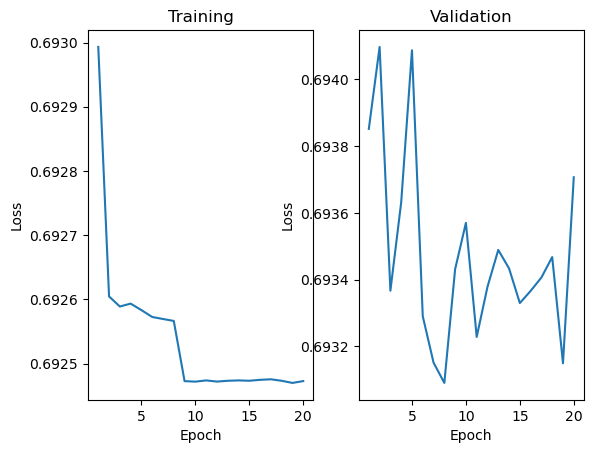

In [12]:

#plot 1:
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training')

#plot 2:
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation')

plt.show()
# plt.savefig('image.png')

In [13]:
torch.save(model.state_dict(), './model/model_v2.pth')